<a href="https://colab.research.google.com/github/hugobrrss/Quant_Finance/blob/main/delta_hedging_trading_strategy_HB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Delta Hedging an Option as a Trading Strategy

## The Black-Scholes Model
The Black-Scholes model is a mathematical framework for pricing European options. It assumes that the price of the underlying asset follows a Geometric Brownian Motion (GBM) with constant drift and volatility.

The Black-Scholes formula for a European call option is:

$$
C(S, t) = S N(d_1) - Ke^{-r(T-t)} N(d_2)
$$

where:

- $ S $ = Current stock price
- $ K $ = Strike price
- $ T $ = Time to expiration
- $ r $ = Risk-free rate
- $ \sigma $ = Volatility
- $ N(d) $ = CDF of the standard normal distribution
- $ d_1 = \frac{\ln(S/K) + (r + \sigma^2/2)(T-t)}{\sigma \sqrt{T-t}} $
- $ d_2 = d_1 - \sigma \sqrt{T-t} $

Next, we'll implement the Black-Scholes formula in Python.


In [1]:
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt

# Black-Scholes pricing function for a European Call option
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)
    delta = si.norm.cdf(d1)  # Delta of the call option
    return call_price, delta

In [31]:
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive

# Function to update the plot
def update(K=100, T=1, r=0.05, sigma=0.2):
    S_range = np.linspace(50, 150, 100)
    prices = []
    deltas = []

    for s in S_range:
        price, delta = black_scholes_call(s, K, T, r, sigma)
        prices.append(price)
        deltas.append(delta)

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(S_range, prices, 'b-', label='Option Price')
    ax2.plot(S_range, deltas, 'r-', label='Delta')

    ax1.set_xlabel('Stock Price (S)')
    ax1.set_ylabel('Option Price', color='b')
    ax2.set_ylabel('Delta', color='r')

    ax1.tick_params(axis='y', colors='b')
    ax2.tick_params(axis='y', colors='r')

    plt.title('Black-Scholes Option Pricing & Delta')
    plt.show()

# Create interactive sliders
interactive_plot = interactive(update,
                               K=widgets.FloatSlider(min=50, max=150, step=1, value=100, description='K'),
                               T=widgets.FloatSlider(min=0, max=5, step=0.1, value=1, description='T'),
                               r=widgets.FloatSlider(min=0, max=0.2, step=0.01, value=0.05, description='r'),
                               sigma=widgets.FloatSlider(min=0.05, max=1, step=0.05, value=0.2, description='sigma'))

interactive_plot

interactive(children=(FloatSlider(value=100.0, description='K', max=150.0, min=50.0, step=1.0), FloatSlider(va…

## Geometric Brownian Motion
Geometric Brownian Motion (GBM) models stock price evolution as:

$$
dS_t = \mu S_t dt + \sigma S_t dW_t
$$

where:
- $ \mu $ = Drift (expected return)
- $ \sigma $ = Volatility
- $ dW_t $ = Wiener process

We will now define a function to simulate a stock price path using GBM.


In [16]:
def simulate_gbm(S0, mu, sigma, T, dt=1/252):
    """Simulates a Geometric Brownian Motion (GBM) price path."""
    n_steps = int(T / dt)
    t = np.linspace(0, T, n_steps)
    W = np.random.standard_normal(size=n_steps)
    W = np.cumsum(W) * np.sqrt(dt)  # Wiener process
    S_t = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)
    return S_t, t

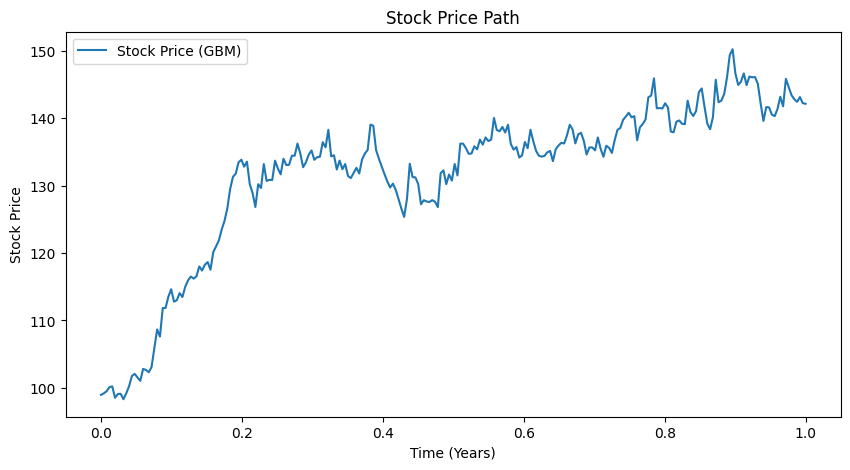

In [4]:
# Example Parameters
S0, K, T, r, sigma, mu = 100, 100, 1, 0.05, 0.2, 0.08

# Run single delta hedge simulation
S_t, t = simulate_gbm(S0, mu, sigma, T)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(t, S_t, label="Stock Price (GBM)")
plt.title("Stock Price Path")
plt.xlabel("Time (Years)")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


## Delta Hedging a Short Call
The delta-hedging strategy consists of:
1. Selling a European call option at the Black-Scholes price.
2. Buying a dynamically adjusted amount of stock to hedge the delta exposure.
3. Rebalancing the hedge throughout the life of the option.
4. Calculating the realized profit/loss at expiration.

The function below simulates the delta-hedging process.


In [99]:
def delta_hedge_simulation(S0, K, T, r, sigma, mu, dt):
    """Simulates a delta hedging strategy for a short call position."""
    # Generate GBM path
    S_t, t = simulate_gbm(S0, mu, sigma, T, dt)

    # Initial Black-Scholes price
    call_price0, delta0 = black_scholes_call(S0, K, T, r, sigma)

    cash = []
    deltas = []
    portfolio_values = []

    # At t=0, short the call, buy delta0 shares
    initial_cash = call_price0 - delta0*S0
    cash.append(initial_cash)
    deltas.append(delta0)
    portfolio_values.append(initial_cash)

    # Iterate over time steps to rebalance hedge
    for i in range(1, len(S_t)):
        tau = T - i*dt  # Time remaining
        call_price, delta = black_scholes_call(S_t[i], K, tau, r, sigma)
        deltas.append(delta)

        # how many shares to buy?
        shares_to_buy = deltas[-1] - deltas[-2]
        cash_t = cash[-1]*np.exp(r*dt) - shares_to_buy*S_t[i]
        cash.append(cash_t)

    # Final profit/loss
    final_pnl = cash[-1] + deltas[-1]*S_t[-1] - max(S_t[-1] - K, 0)

    return S_t, final_pnl, deltas, t, cash


In [100]:
# This is my latest attempt tracking the good things

def delta_hedge_simulation(S0, K, T, r, sigma, mu, dt):
    """Simulates a delta hedging strategy for a short call position."""
    # Generate GBM path
    S_t, t = simulate_gbm(S0, mu, sigma, T, dt)
    # Initialize arrays
    cash = np.zeros(len(S_t))
    shares = np.zeros(len(S_t))
    portfolio_values = np.zeros(len(S_t))

    # t=0: initial Black-Scholes price and delta and filling arrays
    call_price0, delta0 = black_scholes_call(S0, K, T, r, sigma)

    shares[0] = delta0
    cash[0] = call_price0 - delta0*S0
    portfolio_values[0] = cash[0] + shares[0]*S0

    for i in range(1, len(S_t)):
        tau = T - i*dt
        call_price, delta = black_scholes_call(S_t[i], K, tau, r, sigma)

        shares[i] = delta
        cash[i] = cash[i-1]*np.exp(r*dt) - (shares[i]-shares[i-1])*S_t[i]
        portfolio_values[i] = cash[i] + shares[i]*S_t[i]

    # Maturity
    option_payoff = max(S_t[-1]-K,0)
    final_pnl = cash[-1] + shares[-1]*S_t[-1] - option_payoff

    return S_t, final_pnl, shares, t, portfolio_values

Option Price |  9.215114704827258  | Initial Delta |  0.59831437381129


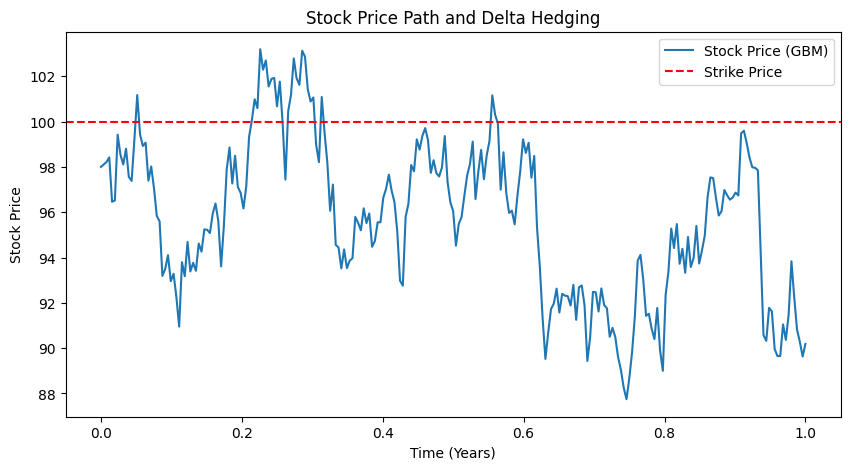

Final P&L from Delta Hedging: -0.71


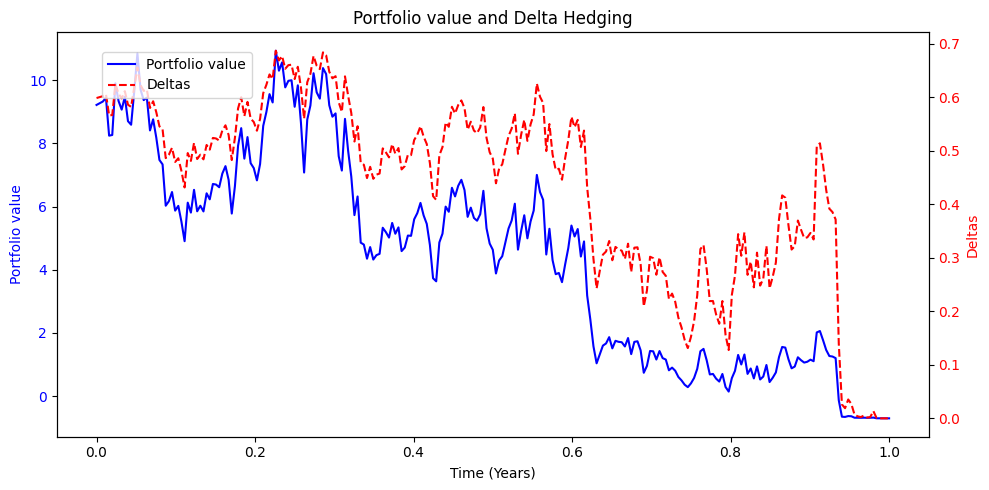

In [108]:
# Example Parameters
S0, K, T, r, sigma, mu, dt = 98, 100, 1, 0.05, 0.2, 0.08, 1/(1*252)

ex = black_scholes_call(S0, K, T, r, sigma)

print('Option Price | ', ex[0], ' | Initial Delta | ', ex[1])

# Run single delta hedge simulation
S_t, final_pnl, deltas, t, portfolio_values = delta_hedge_simulation(S0, K, T, r, sigma, mu, dt)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(t, S_t, label="Stock Price (GBM)")
plt.axhline(K, color='r', linestyle="--", label="Strike Price")
plt.title("Stock Price Path and Delta Hedging")
plt.xlabel("Time (Years)")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

print(f"Final P&L from Delta Hedging: {final_pnl:.2f}")


# Plotting portfolio value
fig, ax1 = plt.subplots(figsize=(10, 5))

# Primary y-axis (left)
ax1.plot(t, portfolio_values, label="Portfolio value", color='blue')
ax1.set_xlabel("Time (Years)")
ax1.set_ylabel("Portfolio value", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Second y-axis (right)
ax2 = ax1.twinx()
ax2.plot(t, deltas, label="Deltas", color='red', linestyle='--')
ax2.set_ylabel("Deltas", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Adding title and legends
plt.title("Portfolio value and Delta Hedging")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9)) # Adjust legend position as needed

plt.tight_layout()
plt.show()

## Monte Carlo Simulation
To analyze the effectiveness of delta hedging, we run the simulation 1000 times and compute the average P/L.


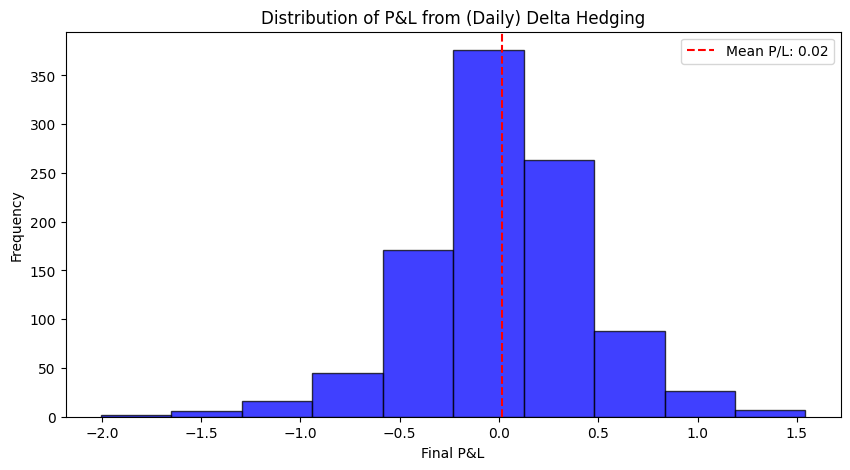

Average P&L over 1000 simulations: 0.0162


In [109]:
n_simulations = 1000
pnl_results = []

for _ in range(n_simulations):
    _, final_pnl, _, _,_ = delta_hedge_simulation(S0, K, T, r, sigma, mu, dt)
    pnl_results.append(final_pnl)

# Plot histogram of outcomes
plt.figure(figsize=(10, 5))
plt.hist(pnl_results, bins=10, alpha=0.75, color="blue", edgecolor="black")
plt.axvline(np.mean(pnl_results), color='r', linestyle="--", label=f"Mean P/L: {np.mean(pnl_results):.2f}")
plt.title("Distribution of P&L from (Daily) Delta Hedging")
plt.xlabel("Final P&L")
plt.ylabel("Frequency")
plt.legend()
plt.show()

print(f"Average P&L over {n_simulations} simulations: {np.mean(pnl_results):.4f}")


### Convergence to Theoretical Price

As per the argument made in their 1973 paper, should the discretization and hedging approach continuous time the expectation of P/L will converge to the theoreical price imposed by the Black-Scholes model.

In [ ]:
"""def delta_hedge_simulation(S0, K, T, r, sigma, mu, dt=1/1000):
    """Simulates a delta hedging strategy for a short call position."""
    # Generate GBM path
    S_t, t = simulate_gbm(S0, mu, sigma, T, dt)

    # Initial Black-Scholes price
    call_price, delta = black_scholes_call(S0, K, T, r, sigma)

    # Short the call, buy delta shares
    initial_cash = call_price - delta * S0  # Initial cash position
    portfolio_value = initial_cash
    deltas = [delta]

    # Iterate over time steps to rebalance hedge
    for i in range(1, len(S_t)):
        tau = T - i * dt  # Time remaining
        call_price, delta = black_scholes_call(S_t[i], K, tau, r, sigma)
        deltas.append(delta)

        # Portfolio value at each step
        portfolio_value = delta * S_t[i] + initial_cash * np.exp(r * i * dt)

    # Final profit/loss
    final_pnl = portfolio_value - max(S_t[-1] - K, 0)  # Payoff of the short call
    return S_t, final_pnl, deltas, t


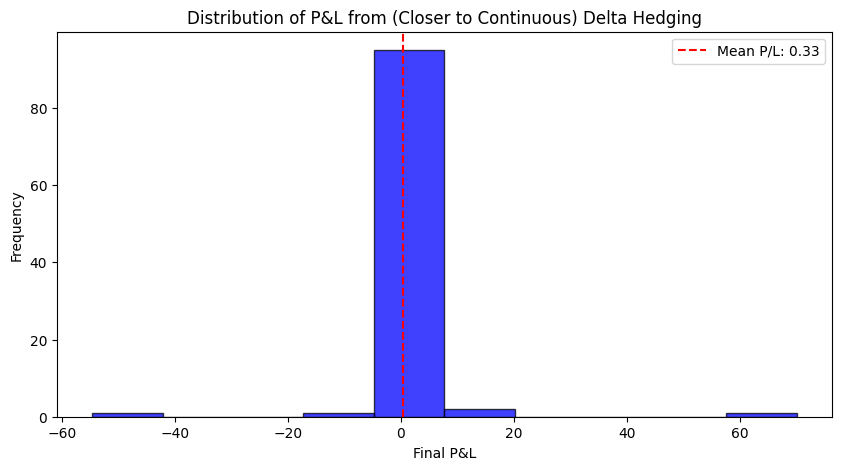

Average P&L over 100 simulations: 0.33


In [ ]:
n_simulations = 100
pnl_results = []
dt = 1/1000
for _ in range(n_simulations):
    _, final_pnl, _, _, _ = delta_hedge_simulation(S0, K, T, r, sigma, mu, dt)
    pnl_results.append(final_pnl)

# Plot histogram of outcomes
plt.figure(figsize=(10, 5))
plt.hist(pnl_results, bins=10, alpha=0.75, color="blue", edgecolor="black")
plt.axvline(np.mean(pnl_results), color='r', linestyle="--", label=f"Mean P/L: {np.mean(pnl_results):.2f}")
plt.title("Distribution of P&L from (Closer to Continuous) Delta Hedging")
plt.xlabel("Final P&L")
plt.ylabel("Frequency")
plt.legend()
plt.show()

print(f"Average P&L over {n_simulations} simulations: {np.mean(pnl_results):.2f}")


### Long Story Short

Our expected P/L conducting a delta hedging scheme that approaches continuous time is simply the premium we collect for the call.

### Applied Example: Opinion on Volatility

Should we have an opinion on the parameterization of the dynamics of the underlying asset then we can conduct a "statistical arbitrage" by delta hedging.

In [ ]:
def delta_hedge_simulation(S0, K, T, r, sigma, mu, dt=1/500, vol_pos=None):
    """Simulates a delta hedging strategy for a short call position."""
    # Initial Black-Scholes price capturing market opinion
    call_price, delta = black_scholes_call(S0, K, T, r, sigma)

    if vol_pos != None:
        sigma = vol_pos

    # Generate GBM path according to our vol opinion
    S_t, t = simulate_gbm(S0, mu, sigma, T, dt)



    # Short the call, buy delta shares
    initial_cash = call_price - delta * S0  # Initial cash position
    portfolio_value = initial_cash
    deltas = [delta]

    # Iterate over time steps to rebalance hedge
    for i in range(1, len(S_t)):
        tau = T - i * dt  # Time remaining
        call_price, delta = black_scholes_call(S_t[i], K, tau, r, sigma)
        deltas.append(delta)

        # Portfolio value at each step
        portfolio_value = delta * S_t[i] + initial_cash * np.exp(r * i * dt)

    # Final profit/loss
    final_pnl = portfolio_value - max(S_t[-1] - K, 0)  # Payoff of the short call
    return S_t, final_pnl, deltas, t


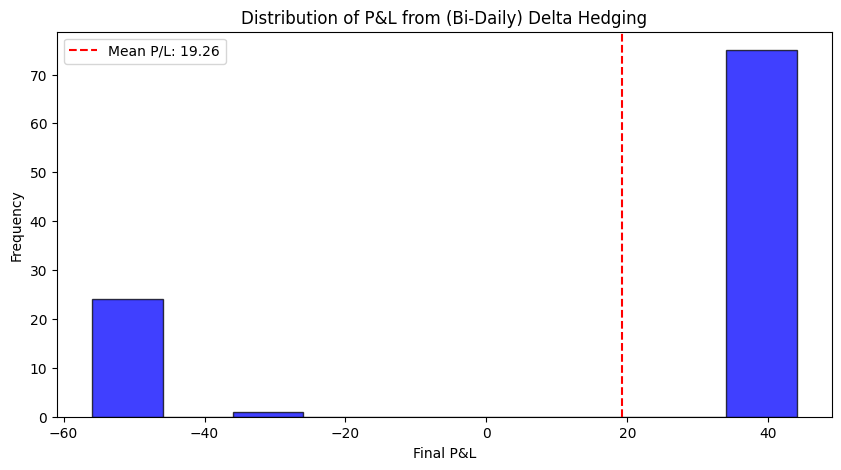

Average P&L over 100 simulations: 19.26


In [ ]:
n_simulations = 100
pnl_results = []

for _ in range(n_simulations):
    _, final_pnl, _, _ = delta_hedge_simulation(S0, K, T, r, sigma, mu, vol_pos=.1)
    pnl_results.append(final_pnl)

# Plot histogram of outcomes
plt.figure(figsize=(10, 5))
plt.hist(pnl_results, bins=10, alpha=0.75, color="blue", edgecolor="black")
plt.axvline(np.mean(pnl_results), color='r', linestyle="--", label=f"Mean P/L: {np.mean(pnl_results):.2f}")
plt.title("Distribution of P&L from (Bi-Daily) Delta Hedging")
plt.xlabel("Final P&L")
plt.ylabel("Frequency")
plt.legend()
plt.show()

print(f"Average P&L over {n_simulations} simulations: {np.mean(pnl_results):.2f}")

# Key Takeaways
- **Delta hedging** helps offset the risk of a short call position, but is not perfect due to discrete rebalancing.
- **Monte Carlo simulations** reveal the distribution of possible P/L outcomes.
- **The strategy's effectiveness** depends on how well Black-Scholes assumptions hold in real markets.

This notebook provides a clear framework for testing and analyzing delta hedging strategies under different conditions. 🚀


In [35]:
a=np.random.normal(size=10)

In [36]:
a

array([-0.13934773,  0.09358275, -0.61499635,  0.7571762 , -0.56114939,
        0.60611137, -1.21964332,  0.28009841,  0.52922942,  0.20517816])

In [37]:
a[-1]+=1

In [38]:
a

array([-0.13934773,  0.09358275, -0.61499635,  0.7571762 , -0.56114939,
        0.60611137, -1.21964332,  0.28009841,  0.52922942,  1.20517816])

Starting 1000 simulations...
Finished 1000 simulations in 62.27 seconds.


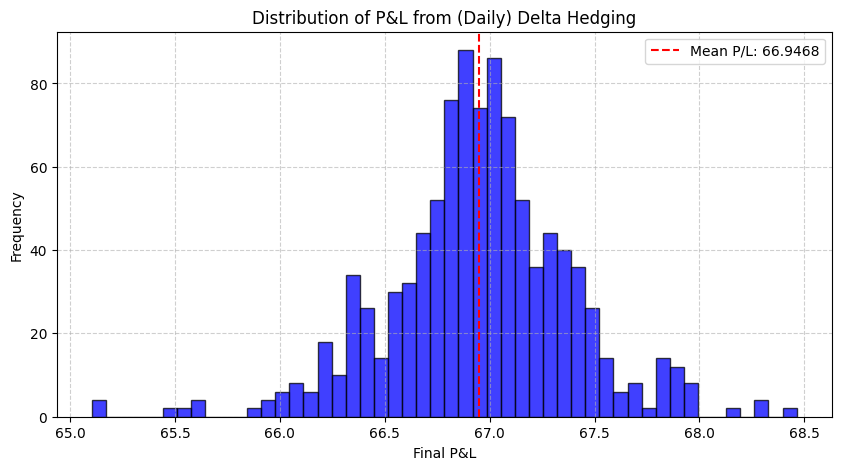

Average P&L over 1000 simulations: 66.9468
Standard Deviation of P&L: 0.4417


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import multiprocessing
import time # For timing the execution

# --- Black-Scholes Call Option Price and Delta ---
def black_scholes_call(S, K, T, r, sigma):
    """
    Calculates the Black-Scholes call option price and its delta.

    Args:
        S (float): Current stock price.
        K (float): Option strike price.
        T (float): Time to expiration (in years).
        r (float): Risk-free interest rate (annualized).
        sigma (float): Volatility of the underlying stock (annualized).

    Returns:
        tuple: (call_price, delta)
    """
    if T <= 0: # Handle expiration
        return max(S - K, 0), (1 if S > K else 0) # Price is intrinsic, delta is 1 if in-the-money, 0 otherwise

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    delta = norm.cdf(d1)
    return call_price, delta

# --- Geometric Brownian Motion Simulation ---
def simulate_gbm(S0, mu, sigma, T, dt=1/252):
    """
    Simulates a Geometric Brownian Motion (GBM) price path.

    Args:
        S0 (float): Initial stock price.
        mu (float): Expected return (drift).
        sigma (float): Volatility.
        T (float): Total time period (in years).
        dt (float): Time step (e.g., 1/252 for daily steps).

    Returns:
        tuple: (S_t, t)
            S_t (numpy.ndarray): Array of simulated stock prices.
            t (numpy.ndarray): Array of time points.
    """
    n_steps = int(T / dt)
    # Ensure n_steps is at least 1 for small T
    if n_steps == 0:
        n_steps = 1
    t = np.linspace(0, T, n_steps + 1) # +1 to include T
    # Generate random numbers for the Wiener process
    # Use n_steps to match the number of price changes
    W = np.random.standard_normal(size=n_steps)
    # Cumulative sum for Wiener process, scaled by sqrt(dt)
    W = np.cumsum(W) * np.sqrt(dt)
    # Prepend 0 to W for the initial time point t=0
    W = np.insert(W, 0, 0)

    S_t = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)
    return S_t, t

# --- Delta Hedging Simulation ---
def delta_hedge_simulation(params):
    """
    Simulates a delta hedging strategy for a short call position.
    This function is designed to be run in parallel, so it takes a single
    tuple of parameters.

    Args:
        params (tuple): A tuple containing (S0, K, T, r, sigma, mu, dt).

    Returns:
        float: The final profit/loss of the hedging strategy.
    """
    S0, K, T, r, sigma, mu, dt = params

    # Generate GBM path
    S_t, t = simulate_gbm(S0, mu, sigma, T, dt)

    # Initial Black-Scholes price and delta
    # Use S_t[0] for the initial stock price
    call_price, delta = black_scholes_call(S_t[0], K, T, r, sigma)

    # Short the call, buy delta shares
    # Initial cash needed to fund the delta shares after receiving option premium
    # We are short the call, so we receive call_price.
    # We buy delta shares, costing delta * S0.
    # So, initial_cash is the cash remaining after buying shares.
    initial_cash = call_price - delta * S_t[0]

    # Portfolio value at t=0 (shares + cash)
    portfolio_value = delta * S_t[0] + initial_cash
    deltas = [delta]
    portfolio_values = [portfolio_value]

    # Iterate over time steps to rebalance hedge
    # Start from the second time step (index 1) as initial position is at index 0
    for i in range(1, len(S_t)):
        tau = T - t[i]  # Time remaining at current step S_t[i]
        current_S = S_t[i]

        # Calculate new delta based on current stock price and remaining time
        new_call_price, new_delta = black_scholes_call(current_S, K, tau, r, sigma)
        deltas.append(new_delta)

        # Calculate previous portfolio value compounded at risk-free rate
        # This is the value of the portfolio just before rebalancing at current_S
        prev_portfolio_value_compounded = portfolio_values[-1] * np.exp(r * dt)

        # Calculate the change in delta and the cost/gain of rebalancing
        delta_change = new_delta - deltas[-2] # deltas[-2] is the delta from the previous step (i-1)
        rebalancing_cost = delta_change * current_S

        # Update portfolio value after rebalancing
        portfolio_value = prev_portfolio_value_compounded - rebalancing_cost
        portfolio_values.append(portfolio_value)

    # Final profit/loss at expiration
    # The portfolio value at the last step (before option expiry payoff)
    final_portfolio_value_before_payoff = portfolio_values[-1] * np.exp(r * dt)

    # Payoff of the short call at expiration
    option_payoff_at_expiry = max(S_t[-1] - K, 0)

    # Final P&L: (Portfolio value at expiry + value of shares held) - option payoff
    # The portfolio_values[-1] already includes the value of the shares held from the last rebalance
    # So, the final P&L is the final portfolio value plus the option premium received, minus the option's intrinsic value at expiry.
    # A short call means we received premium initially, and we pay out if it's in the money.
    # The portfolio value at the end should ideally cover the option payoff.
    # P&L = (Final portfolio value from hedging) - (Option intrinsic value at expiry)
    # The portfolio_values[-1] is the value of the hedging portfolio *after* the last rebalance.
    # We need to consider the initial premium received and the final option payoff.

    # Let's re-think P&L calculation:
    # P&L = (Initial premium received) - (Cost of hedging) - (Option payoff at expiry)
    # Or, more simply, the final value of the hedging portfolio minus the option's intrinsic value at expiry.
    # The portfolio_values[-1] in the loop is the value of the hedging portfolio at each step.
    # The final P&L is how much money you have left after closing out the hedge and settling the option.

    # The final portfolio value should ideally be the cost of the option at expiry.
    # The P&L is the difference between the initial premium received and the total cost of hedging (including final option payoff).
    # Let's use the definition of P&L as the final value of the hedging portfolio minus the option's intrinsic value.
    # If the hedging is perfect, this should be close to zero.

    # The `portfolio_values[-1]` is the value of the hedging portfolio *just before* the final expiry.
    # We need to compound it one last time to the expiry date.
    # Then, we subtract the payoff of the short call.
    #final_pnl = portfolio_values[-1] - max(S_t[-1] - K, 0) # This reflects the final cash in hand after settling the option
    final_pnl = final_portfolio_value_before_payoff + deltas[-1]*S_t[-1]- option_payoff_at_expiry

    return final_pnl

# --- Main execution block ---
if __name__ == '__main__':
    # --- Simulation Parameters ---
    S0 = 100        # Initial stock price
    K = 100         # Strike price
    T = 1.0         # Time to expiration (1 year)
    r = 0.05        # Risk-free rate
    sigma = 0.2     # Volatility
    mu = 0.1        # Drift (expected return of the underlying)
    dt = 1/252      # Time step (daily rebalancing)

    n_simulations = 1000 # Increased for better statistical representation and to see parallelization benefits

    # Prepare parameters for parallel execution
    # Each simulation needs the same set of parameters
    simulation_params = [(S0, K, T, r, sigma, mu, dt)] * n_simulations

    # --- Run Simulations in Parallel ---
    print(f"Starting {n_simulations} simulations...")
    start_time = time.time()

    # Use a multiprocessing Pool to distribute the simulations
    # The number of processes can be adjusted, or left as default (number of CPU cores)
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        # pool.map applies the function to each item in the iterable
        pnl_results = pool.map(delta_hedge_simulation, simulation_params)

    end_time = time.time()
    print(f"Finished {n_simulations} simulations in {end_time - start_time:.2f} seconds.")

    # --- Plotting Results ---
    plt.figure(figsize=(10, 5))
    plt.hist(pnl_results, bins=50, alpha=0.75, color="blue", edgecolor="black") # Increased bins for more detail
    plt.axvline(np.mean(pnl_results), color='r', linestyle="--", label=f"Mean P/L: {np.mean(pnl_results):.4f}")
    plt.title("Distribution of P&L from (Daily) Delta Hedging")
    plt.xlabel("Final P&L")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    print(f"Average P&L over {n_simulations} simulations: {np.mean(pnl_results):.4f}")
    print(f"Standard Deviation of P&L: {np.std(pnl_results):.4f}")
